#### Notebook which allows to download single day CMEMS data (netcdf) to a folder, then import that data, convert it to an xarray and then apply the 3 algorithms (Canny, BOA and CCA) and then save the resulting arrays in a NetCDF file


## VERY IMPORTANT:
### To download CMEMS data the user must have an account in the Copernicus Marine Service

In [25]:
import motuclient
from datetime import date, timedelta
import numpy as np
import xarray as xr
import os
from scipy.ndimage import gaussian_filter
import matplotlib
import cv2
import netCDF4 as nc
from global_land_mask import globe
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = 12, 8

In [2]:
from ipynb.fs.full.CCA_functions_xarray import getFrontInWindow
from ipynb.fs.full.CCA_functions_xarray import CCA_SIED

In [3]:
from ipynb.fs.full.BOA_functions import boa

## ------------------------ DOWNLOAD CMEMS_REANALYSIS DATA -----------------------------------

In [7]:
# this class will be used to parse the motuclient options from a dictionary:
class MotuOptions:
    def __init__(self, attrs: dict):
        super(MotuOptions, self).__setattr__("attrs", attrs)

    def __setattr__(self, k, v):
        self.attrs[k] = v

    def __getattr__(self, k):
        try:
            return self.attrs[k]
        except KeyError:
            return None

In [8]:
#This objective of this function is:   
# post-process the script_template (displayed clicking on VIEW SCRIPT) to create a dictionary; returns this dictionary to feed the download of the data request
def motu_option_parser(script_template, usr, pwd, output_filename, output_directory):
    dictionary = dict([e.strip().partition(" ")[::2] for e in script_template.split('--')])
    dictionary['variable'] = [value for (var, value) in [e.strip().partition(" ")[::2] for e in script_template.split('--')] if var == 'variable']  
    for k, v in list(dictionary.items()):
        if v == '<OUTPUT_DIRECTORY>':
            dictionary[k] = output_directory
        if v == '<OUTPUT_FILENAME>':
            dictionary[k] = output_filename
        if v == '<USERNAME>':
            dictionary[k] = usr
        if v == '<PASSWORD>':
            dictionary[k] = pwd
        if k in ['longitude-min', 'longitude-max', 'latitude-min', 'latitude-max']:
            dictionary[k] = float(v)
        if k in ['date-min', 'date-max']:
            dictionary[k] = v[1:-1]
        dictionary[k.replace('-','_')] = dictionary.pop(k)
    dictionary.pop('python')
    dictionary['auth_mode'] = 'cas'
    return dictionary


In [9]:
def download_CMEMS(day_txt, USERNAME, PASSWORD, OUTPUT_DIRECTORY='../data/CMEMS_daily_data'):
    
    """
    Function to download CMEMS data for a certain day. day_txt is in format %Y-%m-%d.
    The NetCDF will be stored in the CMEMS_daily_data folder. But one can change this.
    
    VERY IMPORTANT: --> to download CMEMS data is required a create an account in the Copernicus Marine Service
    So its necessary to have a USERNAME and a PASSWORD
    """

    base_path = os.getcwd()

    #Check if folder exists. If it don't create it
    exist_path = os.path.exists(os.path.join(base_path, '../data/CMEMS_daily_data'))
    if not exist_path:
        os.makedirs(os.path.join(base_path, '../data/CMEMS_daily_data'))
    
    #Get the data in the format we want: data always at 12:30
    date_motu_txt = day_txt + ' 12:30:00'

    OUTPUT_FILENAME = 'CMEMS_' + day_txt +'.nc'

    script_template = f'python -m motuclient \
        --motu https://nrt.cmems-du.eu/motu-web/Motu \
        --service-id IBI_ANALYSISFORECAST_PHY_005_001-TDS \
        --product-id cmems_mod_ibi_phy_anfc_0.027deg-2D_PT1H-m \
        --longitude-min -19 --longitude-max -5 \
        --latitude-min 35 --latitude-max 45 \
        --date-min "{date_motu_txt}" --date-max "{date_motu_txt}" \
        --variable thetao \
        --out-dir <OUTPUT_DIRECTORY> \
        --out-name <OUTPUT_FILENAME> \
        --user <USERNAME> --pwd <PASSWORD>'
    

    data_request_options_dict_automated = motu_option_parser(script_template, USERNAME, PASSWORD, OUTPUT_FILENAME, OUTPUT_DIRECTORY)
    #print(data_request_options_dict_automated)
    
    motuclient.motu_api.execute_request(MotuOptions(data_request_options_dict_automated))

In [13]:
download_CMEMS('2022-10-24', USERNAME=username, PASSWORD=password, OUTPUT_DIRECTORY = '../data/CMEMS_daily_data')

## Function to get CMEMS data from folder CMEMS_daily_data

In [14]:
def get_data(filename):
    
    """
    Function to get our netCDF file that is stored in the data directory inside the MUR_seasonal_data folder and convert it to a dataframe.
    The data parameter is the string name of the netCDF file we want to import
    """
    
    base_path = os.getcwd()
    data_folder = os.path.join(base_path, "../data/CMEMS_daily_data")  
    
    nc_path = os.path.join(data_folder, filename)
    data_xarray = xr.load_dataset(nc_path)
    
    #for the xarray have the same nomenclature 
    data_xarray = data_xarray.rename({'latitude':'lat', 'longitude':'lon', 'thetao':'analysed_sst'})
    
    return data_xarray

In [15]:
xarray_cmems = get_data('CMEMS_2022-10-24.nc')

In [16]:
xarray_cmems

<xarray.Dataset>
Dimensions:       (lat: 361, lon: 505, time: 1)
Coordinates:
  * lat           (lat) float32 35.0 35.03 35.06 35.08 ... 44.94 44.97 45.0
  * time          (time) datetime64[ns] 2022-10-24T12:30:00
  * lon           (lon) float32 -19.0 -18.97 -18.94 ... -5.056 -5.028 -5.0
Data variables:
    analysed_sst  (time, lat, lon) float32 22.17 22.16 22.15 ... 18.89 18.84
Attributes: (12/24)
    Conventions:                        CF-1.0
    title:                              Ocean surface hourly mean fields for ...
    source:                             NEMO3.6
    domain_name:                        IBI36
    FROM_ORIGINAL_FILE__field_type:     mean
    field_date:                         20230307
    ...                                 ...
    institution:                        Nologin (Spain)
    references:                         http://marine.copernicus.eu/
    contact:                            mailto: servicedesk.cmems@mercator-oc...
    _CoordSysBuilder:                   ucar.nc2.dataset.conv.CF1Convention
    comment:                            
    history:                            Data extracted from dataset http://lo...

## -------------------------------------------- Canny Algorithm ------------------------------------------------

In [26]:

def canny_front_detection_1day(data_xarray, thresh_min=210, thresh_max=230, apertureSize=5, sigma=3):
    
    """
    This function receives a dataframe with CMEMS Forecast data for a individual day and returns the array 
    that result from the aplication of the Canny Algorithm from OpenCV. 
    For visualization purposes, one can change the minimum and maximum threshold.
    One can also apply a gaussian filter with a certain sigma value to reduce noise of the image.
    """
    
    #Get the sst array in the right shape
    sst = np.array(data_xarray['analysed_sst'])
    sst = np.squeeze(sst)
    #Convert Temperature values to uint8 format with values in the range of 0-255
    sst_final = ((sst - np.nanmin(sst)) * (1/(np.nanmax(sst) - np.nanmin(sst)) * 255)).astype('uint8')
    sst_final = np.flipud(sst_final)   #flipud -> Reverse the order of elements along axis 0 (up/down).
    #in case we want to apply a gaussian filter with a certain sigma value (by default is 0)
    sst_final = gaussian_filter(sst_final, sigma=sigma)   

    #apply the canny algorithm and plot the image with the edges
    canny = cv2.Canny(sst_final, thresh_min, thresh_max, apertureSize=apertureSize, L2gradient=False)
    
    canny[canny == 255] = 1
    
    #convert 0s to Nans
    canny = canny.astype('float')
    canny[canny == 0] = 'nan'

    canny_front = np.flipud(canny)  
    
    
    lat_dims = data_xarray.dims['lat']
    lon_dims = data_xarray.dims['lon']
    
    lat_max = data_xarray['lat'].values.max()
    lat_min = data_xarray['lat'].values.min()
    lon_max = data_xarray['lon'].values.max()
    lon_min = data_xarray['lon'].values.min()
    
    # Lat/lon points to get
    lat = np.linspace(lat_min,lat_max,lat_dims)
    lon = np.linspace(lon_min,lon_max,lon_dims)
    # Make a grid
    lon_grid, lat_grid = np.meshgrid(lon,lat)
    # Get whether the points are on land.
    z = globe.is_land(lat_grid, lon_grid)
    canny_front[z == True] = np.nan
    
    
    return canny_front

In [27]:
canny_f = canny_front_detection_1day(xarray_cmems)

In [12]:
np.unique(canny_f)

array([ 1., nan])

In [28]:
def front_visualization(front_array, data_xarray):
    
    """
    Function to visualize the map of the front.
    We use the sst data "analysed_sst" to create a mask for the continental zone
    """
    
    #first we apply the frontal_prob function to a certain period of data
    fp = front_array.copy()
    # replace NaNs with 0s
    fp = np.nan_to_num(fp, nan=0)
    fp = np.flip(fp, axis=0)  #flip along the horizontl axis
    
    df = data_xarray.to_dataframe().reset_index()
    #Create a mask for our continental zone
    sst = df.pivot_table(index='lon', columns='lat', values='analysed_sst').T.values  
    mask = np.isnan(np.flipud(sst))    #Boolean array is True where original array (Temp) had Null values
    mask255 =np.where(mask,(np.ones(mask.shape))*255,0).astype("uint8")   #array which pixels = 255 when mask=True
    #Make a dilation to ensure the pixels that belong to the shore are not consideredd fronts
    kernel = np.ones((3,3), np.uint8)
    mask_dilated = cv2.dilate(mask255, kernel)
    
    fp = np.ma.masked_where(mask_dilated==255, fp)
    
    
    #Visualization purposes: continenal area in gray, and pixels with value=0 in white   
    viridis = matplotlib.cm.get_cmap('viridis', 1)
    newcolor = viridis(np.linspace(0,1,10))
    white = np.array([1, 1, 1, 1])
    newcolor[0, :] = white
    newcmp = ListedColormap(newcolor)
    newcmp.set_bad(color='gray')
    
    #for the definition of the extent in the imshow() -> so we see the values of long and latitude in our plot
    lat = np.array(np.unique(data_xarray['lat'].values))
    lon = np.array(np.unique(data_xarray['lon'].values))

    plt.imshow(fp, cmap=newcmp, extent=[lon[0], lon[-1], lat[0], lat[-1]]) 
    plt.title("Front (CMEMS) ", fontsize=20)

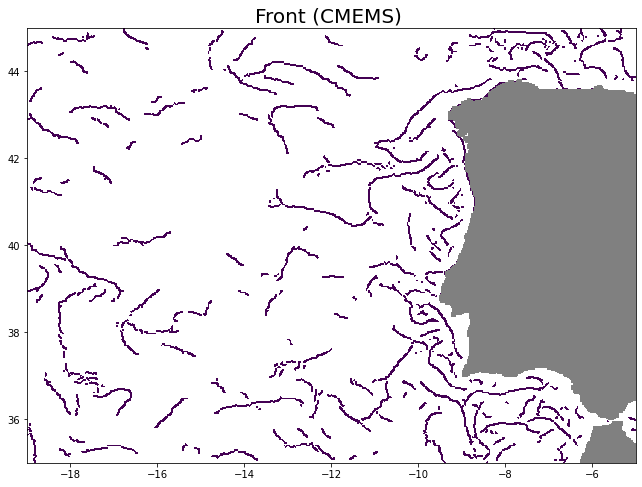

In [29]:
front_visualization(canny_f, xarray_cmems)

## -------------------------------- Belkin O'Reilly Algorithm (BOA) -----------------------------------------

In [30]:

def BOA_aplication(data_xarray, threshold = 0.15):  
    
    """
    Function to, for a given dataframe with a longitude, latitude and SST columns, 
    identifies fronts through the application of BOA algorithm.
    We also need to define a threshold value to later get the frontal probabilities matrix
    (if the pixel value is greater than the threshold, then it is considered a front, otherwise don't). 
    """
    
    lon = np.array(data_xarray['lon']).astype('float64')
    lat = np.array(data_xarray['lat']).astype('float64')
    ingrid = np.array(data_xarray['analysed_sst'])
    ingrid = np.squeeze(ingrid)
    
    
    boa_front = boa(lon=lon, lat=lat, ingrid=ingrid, nodata = np.nan, direction = False)
    boa_front = np.flip(boa_front, axis=0)
    boa_front = np.array([[boa_front[j][i] for j in range(len(boa_front))] for i in range(len(boa_front[0])-1,-1,-1)])
    
    boa_front = np.where(boa_front>=threshold, 1, boa_front)    
    boa_front = np.where(boa_front<threshold, 0, boa_front)
    
    #convert 0s to Nans
    boa_front[boa_front == 0] = 'nan'
    
    boa_front = np.flipud(boa_front) 

    return boa_front


In [31]:
boa_f = BOA_aplication(xarray_cmems, threshold=0.15)

In [15]:
np.unique(boa_f)

array([ 1., nan])

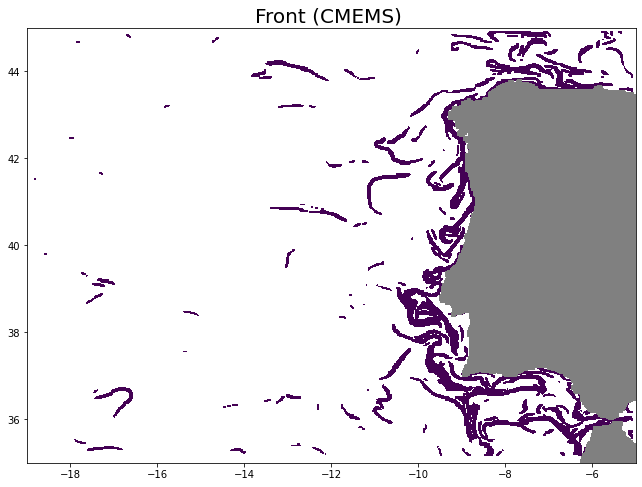

In [32]:
front_visualization(boa_f, xarray_cmems)

## ---------------------------------- Cayula-Cornillon Algorithm (CCA) ------------------------------------

In [33]:
    
def CCA_front(data_xarray): 
    
    """
    Function that calculates the fronts matrix. Given an image (SST data respective to one day) it applies the
    Cayula-Cornillon Algorithm for Single Image Edge Detection (CCA-SIED) to discover the fronts.
    It returns the matrix with the fronts: if pixel = 1 it was considered a front, otherwise, pixel = 0
    It basically converts the (x,y) coordinate points to indexes of the frontal probability matrix. These indexes are considered fronts
    The df parameter is the dataframe with the SST data for a certain day
    """
    
    
    
    lat_dims = data_xarray.dims['lat']
    lon_dims = data_xarray.dims['lon']
    
    lat_max = data_xarray['lat'].values.max()
    lat_min = data_xarray['lat'].values.min()
    lon_max = data_xarray['lon'].values.max()
    lon_min = data_xarray['lon'].values.min()
    
    div_rows = (lat_max-lat_min)/lat_dims
    div_cols = (lon_max-lon_min)/lon_dims
    
    front = np.zeros((lat_dims, lon_dims))       #initialize a matrix of zeros. This shape is for the MUR data
    
    #2 empty arrays that will store the x and y values of the lines that are suposed to be drawn
    x = np.array([])
    y = np.array([])
        
    xdata_final, ydata_final = CCA_SIED(data_xarray)       
    x = np.append(x, xdata_final)
    y = np.append(y, ydata_final)
        
    cols_x = np.array([])
    for value in x:                     #convert values in array x to the respective index in a (1001, 1401) matrix
        aux_x = (-lon_min+value)/div_cols                 #these numbers are relative to the MUR data
        cols_x = np.append(cols_x, aux_x)
    
    rows_y = np.array([])
    for value in y:                     #convert values in array y to the respective index in a (1001, 1401) matrix
        aux_y = (lat_max-value)/div_rows                 #these numbers are relative to the MUR data
        rows_y = np.append(rows_y, aux_y)
     
    cols_x = np.round(cols_x)
    rows_y = np.round(rows_y)
            
    for i in range(len(cols_x)):   #it could also be len(rows_y)
        front[int(rows_y[i]), int(cols_x[i])] = front[int(rows_y[i]), int(cols_x[i])] + 1
            
    front[front != 0] = 1
    
    #convert 0s to Nans
    front[front == 0] = 'nan'
    
    cca_front = np.flipud(front) 
    
    return cca_front


/home/luisfigueiredo/JUNO/notebooks/CCA_functions_xarray.ipynb:79: RuntimeWarning: invalid value encountered in double_scalars
  "    #mask is an array with the same shape of w, that is 1 if in that index position w = np.nan and 0 otherwise\n",
/home/luisfigueiredo/JUNO/notebooks/CCA_functions_xarray.ipynb:177: UserWarning: No contour levels were found within the data range.
  "                if (w[row, col+1] <= thresValue):               #if right pixel < separation\n",


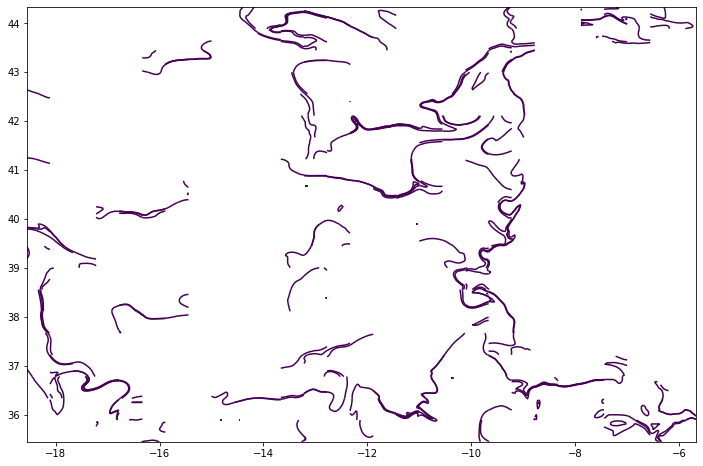

In [34]:
cca_f = CCA_front(xarray_cmems)

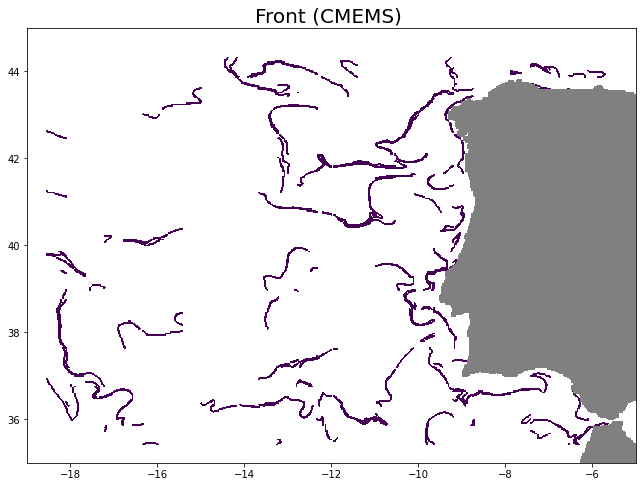

In [35]:
front_visualization(cca_f, xarray_cmems)

## ----------------------------- Real SST Image ----------------------------------

In [37]:
def real_sst_image(data_xarray):
        
    """
    Function to store the real sst image
    """
    
    sst = np.array(data_xarray['analysed_sst'])
    sst = np.squeeze(sst)
    
    return sst

In [38]:
sst_image = real_sst_image(xarray_cmems)

In [40]:
def sst_visualization(front_array, data_xarray):
    
    """
    Function to visualize the map the SST data.
    We use the sst data "analysed_sst" to create a mask for the continental zone.
    """
    
    #first we apply the frontal_prob function to a certain period of data
    fp = front_array.copy()
    fp = np.flip(fp, axis=0)  #flip along the horizontl axis
    
    df = data_xarray.to_dataframe().reset_index()
    #Create a mask for our continental zone
    sst = df.pivot_table(index='lon', columns='lat', values='analysed_sst').T.values  
    mask = np.isnan(np.flipud(sst))    #Boolean array is True where original array (Temp) had Null values
    mask255 =np.where(mask,(np.ones(mask.shape))*255,0).astype("uint8")   #array which pixels = 255 when mask=True
    #Make a dilation to ensure the pixels that belong to the shore are not consideredd fronts
    kernel = np.ones((3,3), np.uint8)
    mask_dilated = cv2.dilate(mask255, kernel)
    
    fp = np.ma.masked_where(mask_dilated==255, fp)
    
    #for the definition of the extent in the imshow() -> so we see the values of long and latitude in our plot
    lat = np.array(np.unique(data_xarray['lat'].values))
    lon = np.array(np.unique(data_xarray['lon'].values))

    plt.imshow(fp, cmap='viridis', extent=[lon[0], lon[-1], lat[0], lat[-1]]) 
    plt.title("Front (MUR) ", fontsize=20)

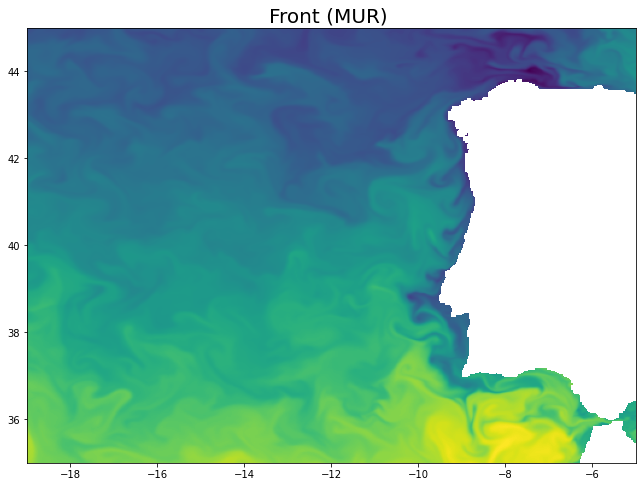

In [41]:
sst_visualization(sst_image, xarray_cmems)

## -------------------------------------- Save results in NetCDF ---------------------------------------------

In [42]:
day_txt = '2022-10-24'

In [43]:

base_path = os.getcwd()
base_path = os.path.join(base_path, '../data')

#Check if exists a folder to save the netcdf. If not create the folder
exist_path = os.path.exists(os.path.join(base_path, 'CMEMS_daily_fronts_netcdf'))    #check if folder CMEMS_daily_fronts_netcdf exists in data folder
if not exist_path:                                                                         #if doesn't exist
    os.makedirs(os.path.join(base_path, 'CMEMS_daily_fronts_netcdf'))                # create the folder


In [46]:
def fronts_2_netcdf(data_xarray, day_txt, sst_image, canny_f, boa_f, cca_f): 
    
    
    """
    File to save the 4 arrays (Canny, BOA, CCA, SST) as NetCDFs. This arrays are regarding a specific day so we
    don't need to have a time variable (either way it can be add this variable if one pleases)
    day_txt is a string in the format Y%m%d
    """
    
    lat_dims = data_xarray.dims['lat']
    lon_dims = data_xarray.dims['lon']
    
    lat_max = data_xarray['lat'].values.max()
    lat_min = data_xarray['lat'].values.min()
    lon_max = data_xarray['lon'].values.max()
    lon_min = data_xarray['lon'].values.min()
    
    
    nc_file = os.getcwd()
    nc_file = os.path.join(nc_file, '../data/CMEMS_daily_fronts_netcdf/CMEMS' + day_txt + '.nc')

    ds = nc.Dataset(nc_file, 'w', format='NETCDF4')

    ds.title = 'CMEMS_ ' + day_txt + ' Fronts Arrays (Xarrays)'

    #create dimensions of the NetCDF file
    #time = ds.createDimension('time')
    lat = ds.createDimension('lat', lat_dims)
    lon = ds.createDimension('lon', lon_dims)

    #times = ds.createVariable('time', 'f4', ('time', ))
    lats = ds.createVariable('lat', 'f4', ('lat', ))
    lons = ds.createVariable('lon', 'f4', ('lon', ))

    sst_analyzed = ds.createVariable('sst', 'f4', ('lat', 'lon',))     #('time', 'lat', 'lon',)
    sst_analyzed.units = 'C'   #degrees Celsius
    sst_analyzed.description = 'Array with the Sea-Surface Temperature (SST) relative to the CMEMS data for that day'
    #sst_analyzed[0, :, :] = sst
    sst_analyzed[:, :] = sst_image

    canny = ds.createVariable('Canny', 'f4', ('lat', 'lon',))
    canny.units = 'Unknown'
    canny.description = 'Binary Array with identyfied fronts through Canny from OpenCV (1-> front), (nan->not front)'
    #canny[0, :, :] = canny_front.astype(float)
    canny[:, :] = canny_f.astype(float)
    
    boa = ds.createVariable('BOA', 'f4', ('lat', 'lon',))
    boa.units = 'Unknown'
    boa.description = 'Binary Array with identyfied fronts through the Belkin O Reilly Algorithm (temperature gradient). If the gradient is bigger than certain threshold is considered front (1) otherwise nan'
    #boa[0, :, :] = boa_front
    boa[:, :] = boa_f
    
    cca = ds.createVariable('CCA', 'f4', ('lat', 'lon',))
    cca.units = 'Unknown'
    cca.description = 'Binary Array with identyfied fronts through the Cayula Cornillon Algorithm (1->front) (nan->not front)'
    #cca[0, :, :] = cca_front.astype(float)
    cca[:, :] = cca_f.astype(float)
    
    #times.units = 'days since 1-1-1'

    lats[:] = np.linspace(lat_min, lat_max, lat_dims)
    lons[:] = np.linspace(lon_min, lon_max, lon_dims)
   
   
    #date_obj = datetime.datetime.strptime(day_txt, '%Y-%m-%d')
    #date_time = date_obj.toordinal()
    #times[:] = date_time

    ds.close()
    

In [48]:
fronts_2_netcdf(xarray_cmems, '2022-10-24', sst_image=sst_image, canny_f=canny_f, boa_f=boa_f, cca_f=cca_f)